In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Point

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_24554/1483661450.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Synthetic Dataset

1. Charging stations scattered around the US (CONUS)
   a. We'll create random coordinatres within the US (perhaps within buffers of cities)

2. To set up the experiment we

3. We will randomly assign 5 treatments (-20%, -10%, 0%, +10%, +20%) where charger prices are experimentally altered
4. We will create data drawn from predefined distributions for usage rates
   a. The data will come from predefined distributions with set mean and variance
   b. For the purpose of the experiment we will purposefully create an affect of price on usage

5. For creating counterfactuals we will try
   a. matching (we'll bring in some ancillary data) and use SMDs
   b. machine learning (xgbclassifier)

In [2]:
# Geography

xmin, ymin, xmax, ymax = -129.37, 24.53, -65.30, 48.67

us_counties = gpd.read_file('/Users/ryangeygan/hacking/Datasets/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

counties = us_counties.cx[xmin:xmax, ymin:ymax]

In [3]:
#Population
census_df = pd.read_csv('/Users/ryangeygan/hacking/Datasets/co-est2023-alldata.csv', encoding='latin1')



In [35]:
points = []

for idx, county in counties.iterrows():
    
    xmin, ymin, xmax, ymax = county.geometry.bounds

    while True:
        try:
            rand_x1 = np.random.uniform(xmin, xmax)
            rand_y1 = np.random.uniform(ymin, ymax)
        
            rand_x2 = np.random.uniform(xmin, xmax)
            rand_y2 = np.random.uniform(ymin, ymax)
        
            p1 = Point(rand_x1, rand_y1)
            p2 = Point(rand_x2, rand_y2)
        
            if county.geometry.contains(p1) and county.geometry.contains(p2):
                points.append(p1)
                points.append(p2)
                
                break
    
        except Exception as e:
            # Handle any exceptions or errors
            print("An error occurred:", e)

In [36]:
chargers_df = gpd.GeoDataFrame(geometry=points)

In [37]:
len(chargers_df)

6216

<Axes: >

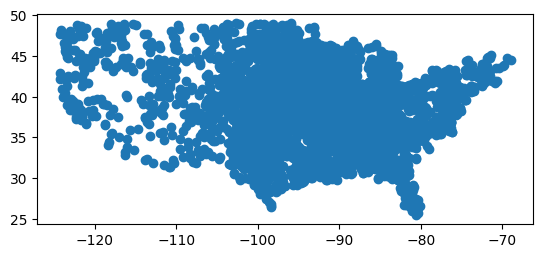

In [18]:
chargers_df.plot()

In [19]:
merged = counties.sjoin(chargers_df)

/Users/ryangeygan/hacking/machine-learning/.venv-machine-learning/lib/python3.12/site-packages/geopandas/geodataframe.py:2187: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [20]:
merged[merged.NAME.isin(list(merged.NAME.sample(frac=0.3)))]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,index_right
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053...",0
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053...",1
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074...",2
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074...",3
21,01,055,00161553,0500000US01055,01055,Etowah,06,1386373604,34568854,"POLYGON ((-86.36962 33.94118, -86.36804 33.942...",14
...,...,...,...,...,...,...,...,...,...,...,...
3226,17,065,00424234,0500000US17065,17065,Hamilton,06,1125696542,3172088,"POLYGON ((-88.70660 37.92190, -88.70644 37.927...",3468
3229,39,075,01074050,0500000US39075,39075,Holmes,06,1094405866,3695230,"POLYGON ((-82.22066 40.66758, -82.19327 40.667...",3470
3229,39,075,01074050,0500000US39075,39075,Holmes,06,1094405866,3695230,"POLYGON ((-82.22066 40.66758, -82.19327 40.667...",3471
3232,26,139,01623012,0500000US26139,26139,Ottawa,06,1459502408,2765830983,"POLYGON ((-86.26432 43.11830, -86.25103 43.118...",3474


In [21]:
merged.NAME.value_counts()

NAME
Washington    32
Franklin      30
Jackson       28
Jefferson     26
Lincoln       26
              ..
Greenwood      2
Story          2
Barton         2
Cloud          2
Gillespie      2
Name: count, Length: 1127, dtype: int64

In [62]:
merged[merged.NAME=='Lavaca']

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,index_right
1609,48,285,01383928,0500000US48285,48285,Lavaca,06,2511535251,1882216,"POLYGON ((-97.23960 29.38551, -97.22918 29.419...",3097
